# Coin Flips

Pretty much every statistical measurement problem starts with coin flips. We will do two different coin flipping models:
- Flip a single coin 100 times
- Flip a collection of 10 coins each 200 times

I do **not** use `arviz` in this notebook. This is to force showing how to extract the information we want from the MCMC chains.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline

## $\S$ 1.1: Flipping a coin 100 times

### Data generation

In [2]:
np.random.seed(42)
flips = np.random.binomial(n=100, p=0.5, size=(1,))

In [3]:
flips

array([49])

### Model

We will model the coin as having a beta binomial prior, with $\alpha = \beta = 40$

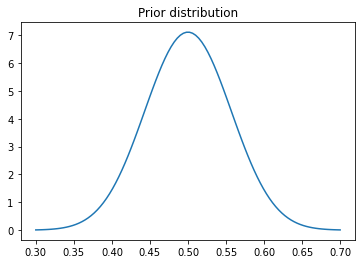

In [4]:
p_space = np.linspace(0.3, 0.7, 100)
plt.plot(p_space, beta(a=40, b=40).pdf(p_space))
plt.title('Prior distribution');

Our model is pretty simple:
```
p ~ beta(40, 40)
N ~ Binomial(100, p)
```

The beta is conjugate to the binomial distribution, so the posterior is simply ```beta(40+flips[0], 40+(100-flips[0])```

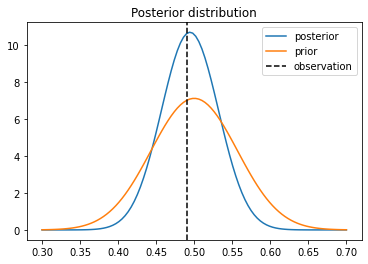

In [5]:
plt.plot(p_space, beta(a=40 + flips[0], b=40 + (100-flips[0])).pdf(p_space), label='posterior')
plt.plot(p_space, beta(a=40, b=40).pdf(p_space), label='prior')
plt.axvline(x=flips[0]/100, label='observation', c='k', ls='--')
plt.legend()
plt.title('Posterior distribution');

### Rewriting this with numpyro

In [6]:
import inspect
import math
import os
import warnings

#import arviz as az

import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [7]:
def model_single_coin_flip(flips=None):
    """Model a single coin flipped 100 times
    
    Generates p once, then the binomial from 100 trials. Numpyro aslo has a betabinomial
    that will allow you to do both in one step.
    """
    p = numpyro.sample("fairness", dist.Beta(40, 40))
    return numpyro.sample("flips", dist.Binomial(total_count=100, probs=p), obs=flips)

In [8]:
chain_run = MCMC(NUTS(model_single_coin_flip), num_warmup=500, num_samples=2500, num_chains=1)

In [9]:
flips

array([49])

In [10]:
chain_run.run(random.PRNGKey(0), flips=flips)

sample: 100%|██████████| 3000/3000 [00:05<00:00, 576.23it/s, 1 steps of size 1.07e+00. acc. prob=0.89]


In [11]:
chain_run.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  fairness      0.49      0.04      0.49      0.44      0.56    780.48      1.00

Number of divergences: 0


Let's show the sample distribution of the `fairness` parameter. We are looking for the "Hairy Catapiller" where lack of flat regions tell us that the posterior was being sampled efficiently.

Notice that the first 500 samples (the warmup / burn-in) do not appear here.

Text(0, 0.5, 'Fairness in sample')

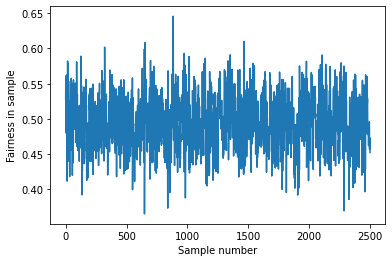

In [12]:
plt.plot(chain_run.get_samples()['fairness'])
plt.xlabel('Sample number')
plt.ylabel('Fairness in sample')

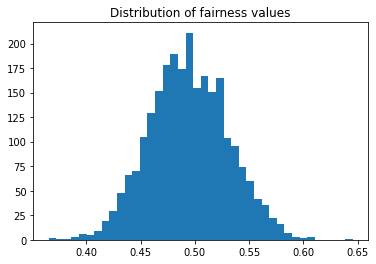

In [13]:
plt.hist(chain_run.get_samples()['fairness'], bins=40)
plt.title('Distribution of fairness values');

Let's compare this to the posterior:

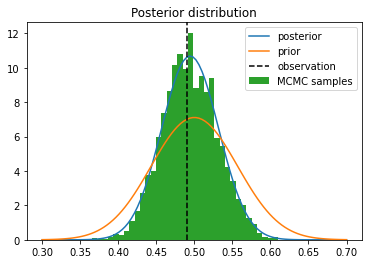

In [14]:
plt.plot(p_space, beta(a=40 + flips[0], b=40 + (100-flips[0])).pdf(p_space), label='posterior')
plt.plot(p_space, beta(a=40, b=40).pdf(p_space), label='prior')
plt.axvline(x=flips[0]/100, label='observation', c='k', ls='--')
plt.hist(chain_run.get_samples()['fairness'], bins=40, density=True, label='MCMC samples');
plt.legend()
plt.title('Posterior distribution');

We see that the MCMC chain makes a reasonable approximation of the analytic answer using the beta binomial approach, so this inspires confidence.

We can also show the confidence interval from the samples directly:

In [15]:
np.quantile(chain_run.get_samples()['fairness'], [0.05, 0.95])

array([0.43623226, 0.55499141])

## $\S$ 1.2: Many coins -- naive

### Data generation

These are the true probability of flipping a head per coin:

In [16]:
np.random.seed(42)
multiple_p = beta.rvs(90, 90, size=(100))

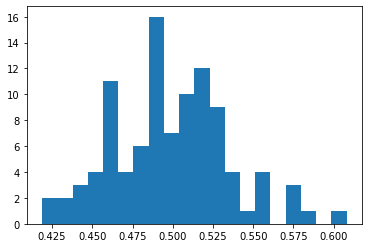

In [17]:
plt.hist(multiple_p, bins=20);

Now let's generate some random data (200 flips per coin)

In [18]:
flips = np.random.binomial(n=200, p=multiple_p)

In [19]:
def multi_coin_model_specify_coin(coin_num, flips):
    n_coins = len(flips)
    p_coins = numpyro.sample("fairness", dist.Beta(40, 40), sample_shape=(n_coins,))
    p_this_coin = p_coins[coin_num]
    return numpyro.sample("heads", dist.Binomial(200, p_this_coin), obs=flips)

In [20]:
chain_run_100_naive = MCMC(NUTS(multi_coin_model_specify_coin), num_warmup=500, num_samples=2500, num_chains=1)

In [21]:
chain_run_100_naive.run(random.PRNGKey(0), coin_num=np.arange(0,100), flips=flips)

sample: 100%|██████████| 3000/3000 [00:05<00:00, 504.95it/s, 7 steps of size 4.35e-01. acc. prob=0.86]  


In [22]:
chain_run_100_naive.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 fairness[0]      0.53      0.03      0.53      0.49      0.58   3144.61      1.00
 fairness[1]      0.47      0.03      0.47      0.42      0.52   2925.67      1.00
 fairness[2]      0.52      0.03      0.52      0.47      0.57   3184.24      1.00
 fairness[3]      0.44      0.03      0.44      0.40      0.49   2826.05      1.00
 fairness[4]      0.53      0.03      0.53      0.48      0.58   2488.49      1.00
 fairness[5]      0.50      0.03      0.50      0.45      0.55   2744.37      1.00
 fairness[6]      0.54      0.03      0.54      0.49      0.59   2259.62      1.00
 fairness[7]      0.47      0.03      0.47      0.42      0.52   2190.77      1.00
 fairness[8]      0.47      0.03      0.47      0.42      0.52   3110.41      1.00
 fairness[9]      0.52      0.03      0.52      0.47      0.57   2627.78      1.00
fairness[10]      0.56      0.03      0.56      0.51      0.60   2805.88      1.00
fai

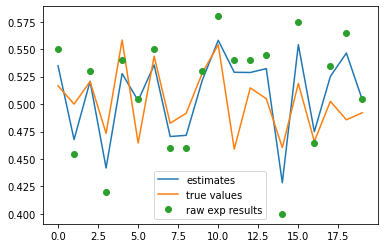

In [23]:
# compare the actual values with the true values
estimates = chain_run_100_naive.get_samples()['fairness'].mean(axis=0)
low, high = 0, 20
plt.plot(estimates[low:high], label='estimates')
plt.plot(multiple_p[low:high], label='true values')
plt.plot(flips[low:high]/200, 'o', label='raw exp results')
plt.legend()

### $\S$ 1.3: Multiple coins, but using "plates"

Let's use the same generated data, but this time use the plate technique we see in the documentation (e.g. [here](http://num.pyro.ai/en/stable/examples/baseball.html))

In [24]:
def multi_coin_model_specify_coin_plate(flips):
    """Using plates to flip multiple coins. 
    
    The value p is broadcast to the different chains"""
    n_coins = len(flips)
    with numpyro.plate('num_coins', n_coins):
        p = numpyro.sample("fairness", dist.Beta(40, 40))
        return numpyro.sample("heads", dist.Binomial(200, p), obs=flips)

In [25]:
chain_run_100_plates = MCMC(NUTS(multi_coin_model_specify_coin_plate), num_warmup=500, num_samples=2500, num_chains=1)

In [26]:
chain_run_100_plates.run(random.PRNGKey(0), flips=flips)

sample: 100%|██████████| 3000/3000 [00:05<00:00, 556.63it/s, 15 steps of size 4.20e-01. acc. prob=0.87] 


In [27]:
chain_run_100_plates.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 fairness[0]      0.54      0.03      0.54      0.49      0.59   4113.77      1.00
 fairness[1]      0.47      0.03      0.47      0.42      0.52   4151.37      1.00
 fairness[2]      0.52      0.03      0.52      0.48      0.57   3806.68      1.00
 fairness[3]      0.44      0.03      0.44      0.40      0.49   3830.15      1.00
 fairness[4]      0.53      0.03      0.53      0.48      0.58   3483.28      1.00
 fairness[5]      0.50      0.03      0.50      0.45      0.55   3771.00      1.00
 fairness[6]      0.54      0.03      0.54      0.49      0.59   3981.65      1.00
 fairness[7]      0.47      0.03      0.47      0.43      0.52   3233.43      1.00
 fairness[8]      0.47      0.03      0.47      0.42      0.52   3525.74      1.00
 fairness[9]      0.52      0.03      0.52      0.47      0.57   3034.55      1.00
fairness[10]      0.56      0.03      0.56      0.51      0.60   4319.82      1.00
fai

## $\S$1.4: One more model

Let's try pooling information from our coins to estimate the parameters of the coin distribution. That is, we will have

```
alpha ~ Exponential(60)
beta ~ Exponential(60)
p[i] ~ Beta(alpha, beta)
heads[i] ~ Binomial(200, p[i]) 
```

In [28]:
def hyperparam_coin_model(flips):
    """Using plates to flip multiple coins. 
    
    The value p is broadcast to the different chains"""
    n_coins = len(flips)
    alpha = numpyro.sample("alpha", dist.Exponential(0.01))
    beta = numpyro.sample("beta", dist.Exponential(0.01))
    
    with numpyro.plate('num_coins', n_coins):
        p = numpyro.sample("fairness", dist.Beta(alpha, beta))
        return numpyro.sample("heads", dist.Binomial(200, p), obs=flips)

In [29]:
chain_run_hyper = MCMC(NUTS(hyperparam_coin_model), num_warmup=500, num_samples=2500, num_chains=1)

In [30]:
chain_run_hyper.run(random.PRNGKey(0), flips=flips)

sample: 100%|██████████| 3000/3000 [00:06<00:00, 441.05it/s, 127 steps of size 3.72e-02. acc. prob=0.94]


In [31]:
chain_run_hyper.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha    115.43     33.21    110.79     64.25    163.99    531.41      1.00
        beta    116.05     33.45    111.60     59.98    159.88    522.57      1.00
 fairness[0]      0.52      0.02      0.52      0.48      0.56   4766.42      1.00
 fairness[1]      0.48      0.03      0.48      0.44      0.52   4317.86      1.00
 fairness[2]      0.51      0.02      0.51      0.47      0.55   4869.74      1.00
 fairness[3]      0.46      0.03      0.46      0.42      0.50   3399.71      1.00
 fairness[4]      0.52      0.03      0.52      0.48      0.56   5311.82      1.00
 fairness[5]      0.50      0.02      0.50      0.46      0.54   5258.38      1.00
 fairness[6]      0.52      0.02      0.52      0.48      0.56   5151.03      1.00
 fairness[7]      0.48      0.03      0.48      0.44      0.52   4919.73      1.00
 fairness[8]      0.48      0.03      0.48      0.44      0.52   6529.35      1.00
 fa

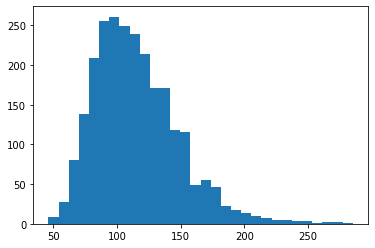

In [32]:
plt.hist(chain_run_hyper.get_samples()['alpha'], bins=30);

We see the priors are not particularly well constrained, but that this specification does the "right thing" and only produces two priors that are pooled across the sample.